In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('wordnet')
tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Getting the Data

In [3]:
def irony_and_sarcasm(row):
  return 1 if row["class"] == "irony" or row["class"] == "sarcasm" else 0

train_set = pd.read_csv("/content/train.csv")
train_set["irony"] = train_set.apply(lambda row: irony_and_sarcasm(row), axis = 1)
test_set = pd.read_csv("/content/test.csv")
test_set["irony"] = test_set.apply(lambda row: irony_and_sarcasm(row), axis = 1)

data_train = train_set[['tweets','irony']]
data_test = test_set[['tweets','irony']]

data = pd.concat([data_train, data_test],axis=0)

In [4]:
data

,tweets,irony
0,Be aware dirty step to get money #staylight ...,0
1,#sarcasm for #people who don't understand #diy...,0
2,@IminworkJeremy @medsingle #DailyMail readers ...,0
3,@wilw Why do I get the feeling you like games?...,0
4,-@TeacherArthurG @rweingarten You probably jus...,0
...,...,...
8123,Why yes I will totally submit my photos to a s...,1
8124,Test on a Saturday! Thank you uni! #sarcasm @ ...,1
8125,Listening to @StephenKing's Misery isn't at al...,1
8126,@mmcpatt There you go being kind again #sarcas...,1


In [5]:
data.dropna(inplace=True)

print(data.info())
print(round(data['irony'].value_counts()*100/len(data),2))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89534 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  89534 non-null  object
 1   irony   89534 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB
None
1    51.14
0    48.86
Name: irony, dtype: float64


# 2. Data Preprocessing

In [6]:
# use NER (named entity recogition) to identify numbers
# similar to gate tokenization

stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    tweet = re.sub('\s+\n+', ' ', x)
    tweet = re.sub('[^a-zA-Z0-9]', ' ', x)
    tweet = tweet.lower()
    tweet = tweet.split()
    
    tweet = [lemm.lemmatize(word, "v") for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    
    return tweet

In [7]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['tweets'].progress_apply(get_entities)

100%|██████████| 89534/89534 [11:34<00:00, 128.99it/s]


In [8]:
data['clean_tweet'] = data['tweets'].apply(text_cleaning)

In [9]:
data['sentence_length'] = data['clean_tweet'].apply(lambda x: len(x.split()))
data

,tweets,irony,entity,clean_tweet,sentence_length
0,Be aware dirty step to get money #staylight ...,0,"MONEY,MONEY",aware dirty step get money staylight staywhite...,12
1,#sarcasm for #people who don't understand #diy...,0,"CARDINAL,CARDINAL,MONEY,PERSON",sarcasm people understand diy artattack http c...,8
2,@IminworkJeremy @medsingle #DailyMail readers ...,0,"MONEY,CARDINAL",iminworkjeremy medsingle dailymail readers sen...,11
3,@wilw Why do I get the feeling you like games?...,0,PERSON,wilw get feel like game sarcasm,6
4,-@TeacherArthurG @rweingarten You probably jus...,0,,teacherarthurg rweingarten probably miss text ...,6
...,...,...,...,...,...
8123,Why yes I will totally submit my photos to a s...,1,CARDINAL,yes totally submit photos shitty online magazi...,12
8124,Test on a Saturday! Thank you uni! #sarcasm @ ...,1,"DATE,ORG,PERSON",test saturday thank uni sarcasm griffith unive...,12
8125,Listening to @StephenKing's Misery isn't at al...,1,,listen stephenking misery disconcert sarcasm,5
8126,@mmcpatt There you go being kind again #sarcas...,1,MONEY,mmcpatt go kind sarcasm standup4kids,5


# 3. Building the Model

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [11]:
tweets = data['clean_tweet']
label = data['irony']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(tweets, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [13]:
# tokenization
max_len = 20       
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  101248


In [14]:
# encoding
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [15]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
# defining the actual model

embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           1045300   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 20, 50)           23832     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

# 4. Training the Model

In [18]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [19]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=None)

Epoch 1/10
2239/2239 [==============================] - 51s 19ms/step - loss: 0.5378 - accuracy: 0.7112 - val_loss: 0.5035 - val_accuracy: 0.7387
Epoch 2/10
2239/2239 [==============================] - 22s 10ms/step - loss: 0.4969 - accuracy: 0.7400 - val_loss: 0.5008 - val_accuracy: 0.7386
Epoch 3/10
2239/2239 [==============================] - 21s 9ms/step - loss: 0.4931 - accuracy: 0.7407 - val_loss: 0.5160 - val_accuracy: 0.7377
Epoch 4/10
2239/2239 [==============================] - 21s 9ms/step - loss: 0.4855 - accuracy: 0.7449 - val_loss: 0.5274 - val_accuracy: 0.7318
Epoch 5/10
2239/2239 [==============================] - 21s 9ms/step - loss: 0.4723 - accuracy: 0.7520 - val_loss: 0.5556 - val_accuracy: 0.7247
Epoch 6/10
2239/2239 [==============================] - 20s 9ms/step - loss: 0.4580 - accuracy: 0.7564 - val_loss: 0.6340 - val_accuracy: 0.7021
Epoch 7/10
2239/2239 [==============================] - 21s 9ms/step - loss: 0.4443 - accuracy: 0.7631 - val_loss: 0.6541 - val_

# 5. Evaluating the Model

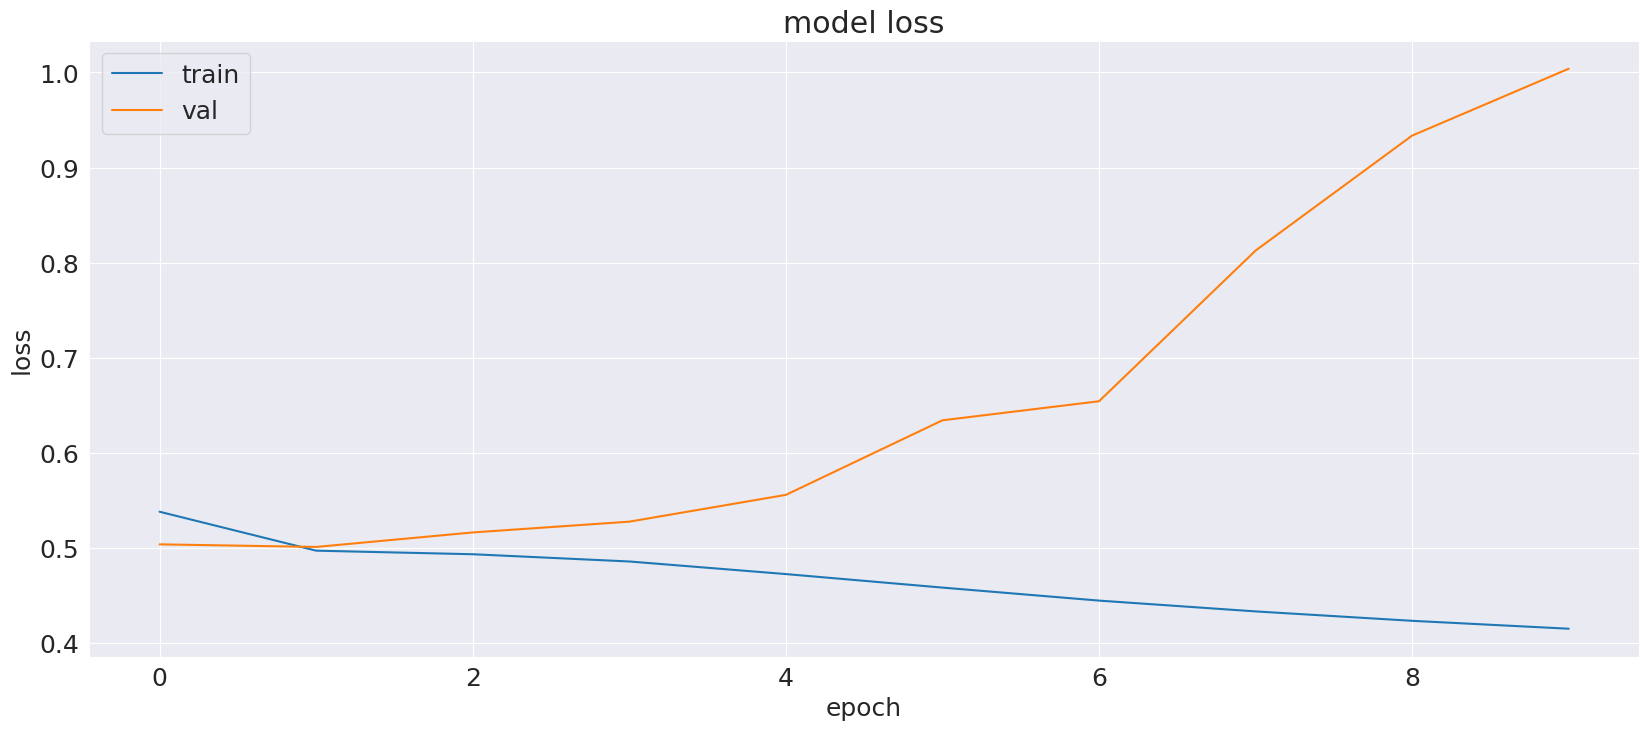

In [20]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

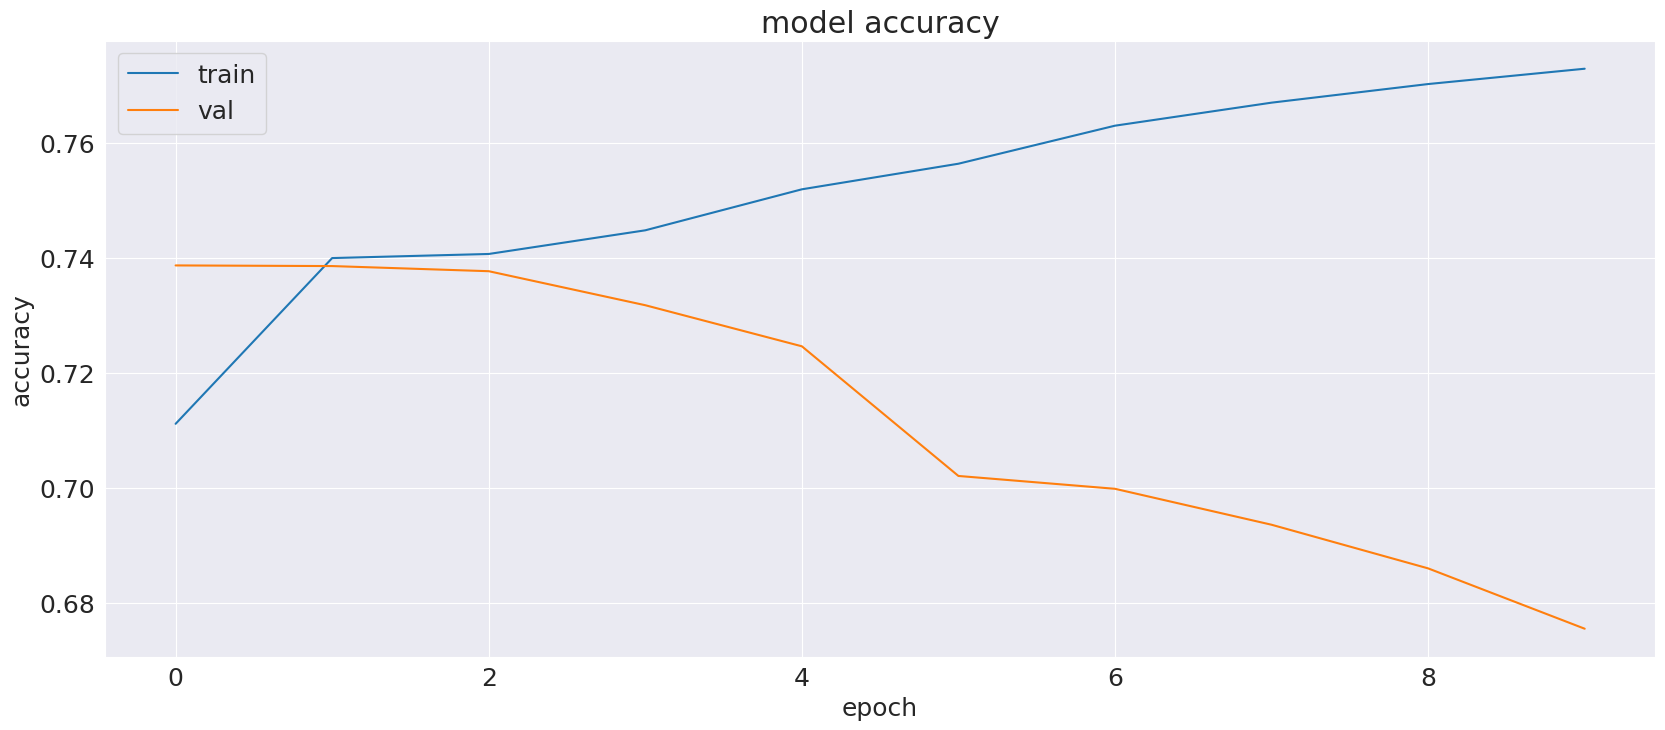

In [21]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y_pred = model.predict(X_test)

280/280 [==============================] - 1s 3ms/step


In [23]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.81      0.61      4375
           1       0.50      0.18      0.26      4579

    accuracy                           0.49      8954
   macro avg       0.49      0.50      0.44      8954
weighted avg       0.49      0.49      0.43      8954



<Axes: >

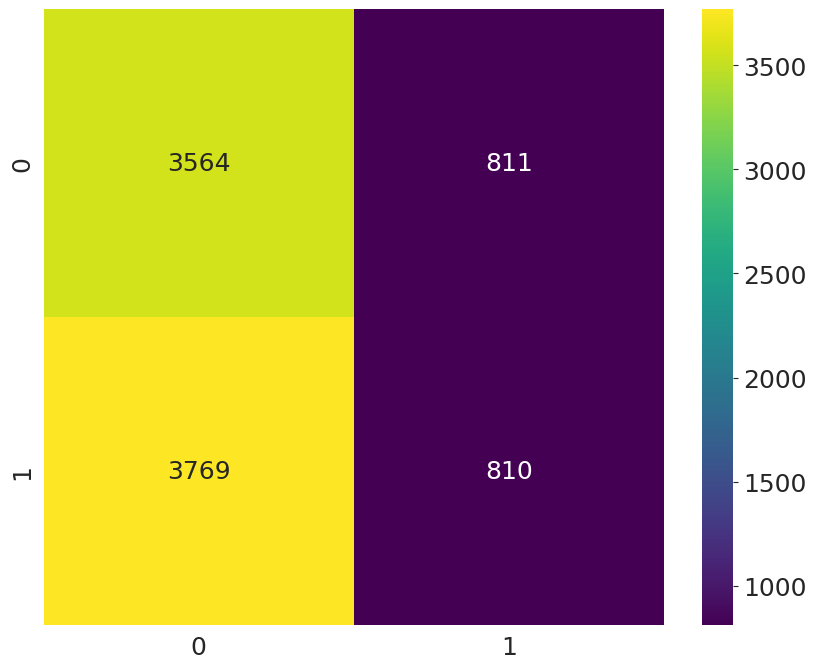

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')